In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

In [ ]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    rt = 0
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt    
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1  
    return (rt+ndt)*ch

In [ ]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    Cont = np.array([])
    SBJ = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta0 = prms['delta0'].values[i]
        delta1 = prms['delta1'].values[i]
        t0 = prms['t0'].values[i]
        
        if model == 'exp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 * np.exp(-lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'hyp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 / (1 + lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'ddm':
            b0 = prms['b0'].values[i]
            ub = lambda t: b0
            lb = lambda t: -1*ub(t)   

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)
        contrast = sbj_data.contrast.values

        rt = []

        for c in contrast:
            delta = delta0 - delta1 * np.log(c)
            rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))

        RT = np.concatenate([RT, rt])
        Cont = np.concatenate([Cont, contrast])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'rt': np.abs(RT),
                         'accuracy': RT>0,
                         'contrast': Cont,
                         'g_contrast': Cont//10*10}) 

In [7]:
data = pd.read_csv('../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data.event == 3]
data = data[data['Duration']<data['rt']].reset_index(drop=True)
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//10*10

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [8]:
hyp_speed = pd.read_csv('_prms/hyp_speed.csv')
hyp_accuracy = pd.read_csv('_prms/hyp_accuracy.csv')
exp_speed = pd.read_csv('_prms/exp_speed.csv')
exp_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
jddm_speed = pd.read_csv('_prms/jddm_speed.csv')
jddm_accuracy = pd.read_csv('_prms/jddm_accuracy.csv')

bhyp_speed = pd.read_csv('_prms/bhyp_speed.csv')
bhyp_accuracy = pd.read_csv('_prms/bhyp_accuracy.csv')
bexp_speed = pd.read_csv('_prms/bexp_speed.csv')
bexp_accuracy = pd.read_csv('_prms/bexp_accuracy.csv')
bddm_speed = pd.read_csv('_prms/bddm_speed.csv')
bddm_accuracy = pd.read_csv('_prms/bddm_accuracy.csv')

In [9]:
pred_hyp_sp = get_model_prediction(hyp_speed, data_speed, 'hyp')
pred_hyp_ac = get_model_prediction(hyp_accuracy, data_accuracy, 'hyp')

100%|██████████| 26/26 [00:10<00:00,  2.40it/s]


In [10]:
pred_bhyp_sp = get_model_prediction(bhyp_speed, data_speed, 'hyp')
pred_bhyp_ac = get_model_prediction(bhyp_accuracy, data_accuracy, 'hyp')

100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


In [11]:
pred_exp_sp = get_model_prediction(exp_speed, data_speed, 'exp')
pred_exp_ac = get_model_prediction(exp_accuracy, data_accuracy, 'exp')

100%|██████████| 26/26 [00:16<00:00,  1.54it/s]


In [12]:
pred_bexp_sp = get_model_prediction(bexp_speed, data_speed, 'exp')
pred_bexp_ac = get_model_prediction(bexp_accuracy, data_accuracy, 'exp')

100%|██████████| 26/26 [00:14<00:00,  1.76it/s]


In [13]:
pred_jddm_sp = get_model_prediction(jddm_speed, data_speed, 'ddm')
pred_jddm_ac = get_model_prediction(jddm_accuracy, data_accuracy, 'ddm')

100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


In [14]:
pred_bddm_sp = get_model_prediction(bddm_speed, data_speed, 'ddm')
pred_bddm_ac = get_model_prediction(bddm_accuracy, data_accuracy, 'ddm')

100%|██████████| 26/26 [00:07<00:00,  3.51it/s]


In [87]:
def get_rt_acc_corr(pred):
    x = [pred[pred['accuracy']==True]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==True) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

def get_rt_acc_incorr(pred):
    x = [pred[pred['accuracy']==False]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==False) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

In [88]:
FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

COLOR_PALETTE = [
    "#286B4E", "#B32935"
]
DATA_ALPHA = 1.0
DATA_MARKER_SIZE = 200
PLOT_TITLES = ['HCT-DDM', 'ECT-DDM', 'FT-DDM']

PREDITOIN_LABLES = ['Prediction - Correct', 'Prediction - Incorrect']

In [89]:
def plot_data_speed():
    x = [data_speed[data_speed['correct']==1]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==1)&(data_speed['rt']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[0], marker='x', label='Data - Correct')
    ax.plot(x, y, c=COLOR_PALETTE[0], alpha=DATA_ALPHA)

    x = [data_speed[data_speed['correct']==0]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==0)&(data_speed['rt']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[1], marker='x', label='Data - Incorrect')
    ax.plot(x, y, c=COLOR_PALETTE[1], alpha=DATA_ALPHA)
    
def plot_data_accuracy():
    x = [data_accuracy[data_accuracy['correct']==1]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==1)&(data_accuracy['rt']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[0], marker='x', label='Data - Correct')
    ax.plot(x, y, c=COLOR_PALETTE[0], alpha=DATA_ALPHA)

    x = [data_accuracy[data_accuracy['correct']==0]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==0)&(data_accuracy['rt']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    ax.scatter(x, y, c=COLOR_PALETTE[1], marker='x', label='Data - Incorrect')
    ax.plot(x, y, c=COLOR_PALETTE[1], alpha=DATA_ALPHA)

### NDT-informed Prediction

In [90]:
predictions = [
    [get_rt_acc_corr(pred_hyp_sp), get_rt_acc_incorr(pred_hyp_sp)],
    [get_rt_acc_corr(pred_exp_sp), get_rt_acc_incorr(pred_exp_sp)],
    [get_rt_acc_corr(pred_jddm_sp), get_rt_acc_incorr(pred_jddm_sp)],
    [get_rt_acc_corr(pred_hyp_ac), get_rt_acc_incorr(pred_hyp_ac)],
    [get_rt_acc_corr(pred_exp_ac), get_rt_acc_incorr(pred_exp_ac)],
    [get_rt_acc_corr(pred_jddm_ac), get_rt_acc_incorr(pred_jddm_ac)]
]

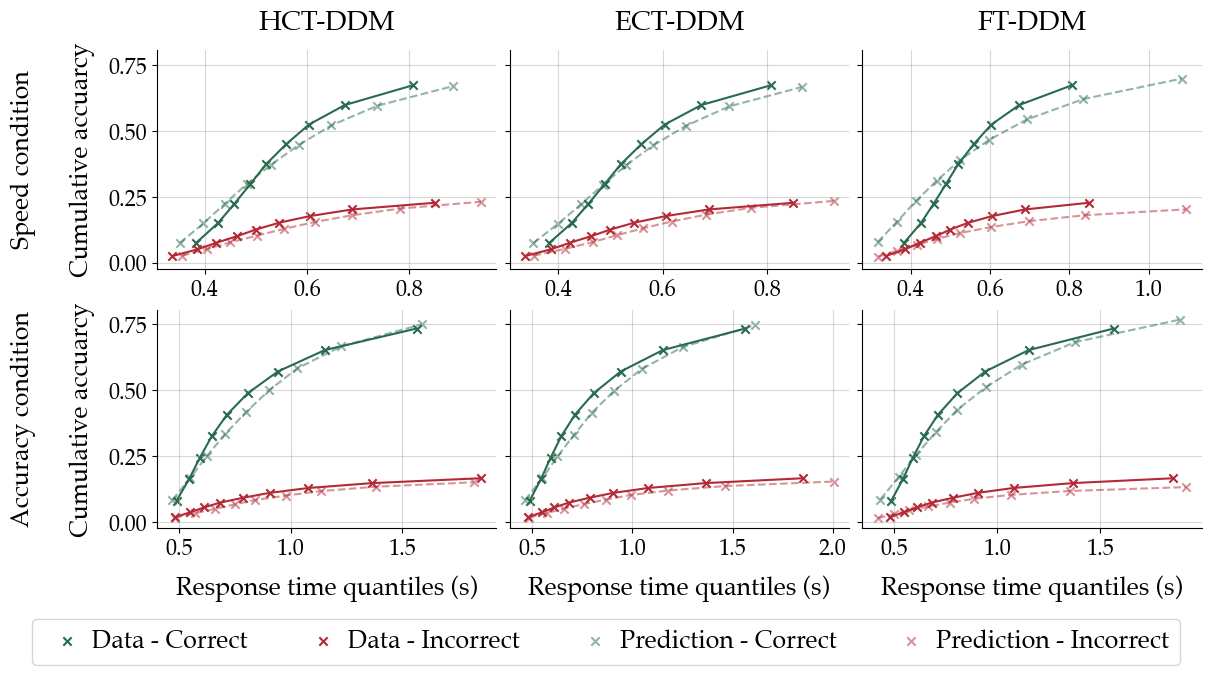

In [96]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharey=True)
for i, ax in enumerate(axs.flat):
    # empirical data
    if i < 3:
        plot_data_speed()
        ax.set_title(PLOT_TITLES[i], fontsize=FONT_SIZE_1, pad=15)
    else:
        plot_data_accuracy()
        ax.set_xlabel('Response time quantiles (s)', fontsize=FONT_SIZE_2, labelpad=10)
    # predicted data
    for j in range(2):
        ax.scatter(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], marker='x', alpha=0.5,
            label=PREDITOIN_LABLES[j]
        )
        ax.plot(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], linestyle='--', alpha=0.5
        )

    if i == 0:
        ax.set_ylabel('Speed condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    if i == 3:
        ax.set_ylabel('Accuracy condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    
    ax.tick_params(labelsize=FONT_SIZE_3)
    ax.grid(alpha=0.5)
sns.despine()

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=4, fontsize=FONT_SIZE_2,
    handletextpad=0.
)

fig.savefig(
    '_plots/S1_preds_NDT_informed.pdf', 
    transparent=True,
    dpi=600,
    bbox_inches='tight'
)

### Uninformed Prediction

In [97]:
predictions = [
    [get_rt_acc_corr(pred_bhyp_sp), get_rt_acc_incorr(pred_bhyp_sp)],
    [get_rt_acc_corr(pred_bexp_sp), get_rt_acc_incorr(pred_bexp_sp)],
    [get_rt_acc_corr(pred_bddm_sp), get_rt_acc_incorr(pred_bddm_sp)],
    [get_rt_acc_corr(pred_bhyp_ac), get_rt_acc_incorr(pred_bhyp_ac)],
    [get_rt_acc_corr(pred_bexp_ac), get_rt_acc_incorr(pred_bexp_ac)],
    [get_rt_acc_corr(pred_bddm_ac), get_rt_acc_incorr(pred_bddm_ac)]
]

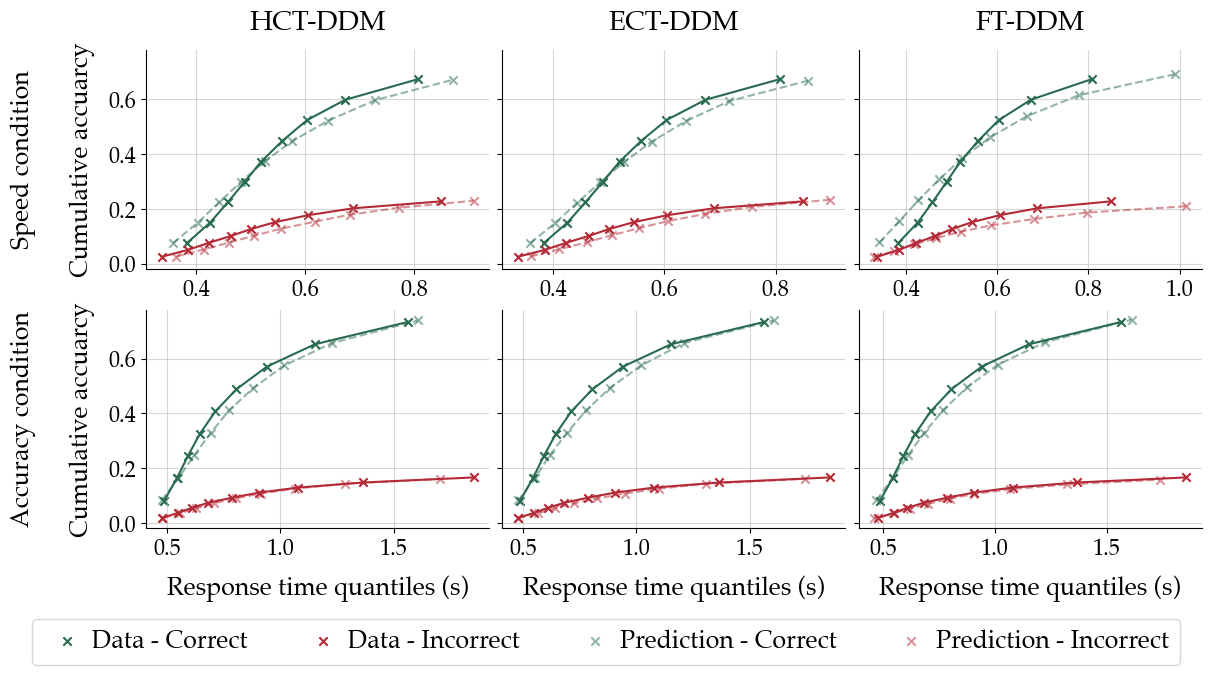

In [98]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout='constrained', sharey=True)
for i, ax in enumerate(axs.flat):
    # empirical data
    if i < 3:
        plot_data_speed()
        ax.set_title(PLOT_TITLES[i], fontsize=FONT_SIZE_1, pad=15)
    else:
        plot_data_accuracy()
        ax.set_xlabel('Response time quantiles (s)', fontsize=FONT_SIZE_2, labelpad=10)
    # predicted data
    for j in range(2):
        ax.scatter(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], marker='x', alpha=0.5,
            label=PREDITOIN_LABLES[j]
        )
        ax.plot(
            predictions[i][j][0], predictions[i][j][1],
            c=COLOR_PALETTE[j], linestyle='--', alpha=0.5
        )

    if i == 0:
        ax.set_ylabel('Speed condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    if i == 3:
        ax.set_ylabel('Accuracy condition\n\nCumulative accuarcy', fontsize=FONT_SIZE_2, labelpad=10)
    
    ax.tick_params(labelsize=FONT_SIZE_3)
    ax.grid(alpha=0.5)
sns.despine()

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=4, fontsize=FONT_SIZE_2,
    handletextpad=0.
)

fig.savefig(
    '_plots/S1_preds_uninformed.pdf', 
    transparent=True,
    dpi=600,
    bbox_inches='tight'
)